In [2]:
import pandas as pd

In [3]:
original=pd.read_csv('../data/crsp_ff_adjusted.csv')
corrected=pd.read_csv('../data/corrected_crsp_ff_adjusted.csv')

In [4]:
original

,Unnamed: 0,date,TICKER,RET,Adj_RET_Mkt,Adj_RET_Mkt_SMB,Adj_RET_Mkt_SMB_HML
0,0,1990-02-01,SUNW,0.012903,7.292903,8.532903,7.682903
1,243076,1990-02-01,MYG,0.014085,7.294085,8.534085,7.684085
2,1688937,1990-02-01,INTC,-0.012658,7.267342,8.507342,7.657342
3,1680427,1990-02-01,CB,0.005634,7.285634,8.525634,7.675634
4,1675688,1990-02-01,BUD,-0.026490,7.253510,8.493510,7.643510
...,...,...,...,...,...,...,...
3266862,228605,2015-12-31,KMI,0.026135,-0.533865,-4.133865,-3.713865
3266863,66360,2015-12-31,ADM,-0.005423,-0.565423,-4.165423,-3.745423
3266864,374087,2015-12-31,HPE,-0.005236,-0.565236,-4.165236,-3.745236
3266865,954405,2015-12-31,DIS,-0.011849,-0.571849,-4.171849,-3.751849


In [5]:
import pandas as pd

# Convert 'date' column to datetime
original['date'] = pd.to_datetime(original['date'])

# Group by year and month, then count unique companies
monthly_companies = original.groupby([original['date'].dt.year, original['date'].dt.month])['TICKER'].nunique()

# Check if around 500 companies per month
print(monthly_companies)
if monthly_companies.between(480, 520).all():
    print("Each month has approximately 500 companies.")
else:
    print("Some months do not have approximately 500 companies.")


date  date
1990  2       496
      3       499
      4       500
      5       500
      6       499
             ... 
2015  8       497
      9       499
      10      499
      11      500
      12      499
Name: TICKER, Length: 311, dtype: int64
Each month has approximately 500 companies.


In [6]:
data=pd.read_csv('../data/crsp_stock_data.csv')
data.head(5)

/Users/jacobbarcelona/.pyenv/versions/3.9.16/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,PERMNO,date,TICKER,COMNAM,PRC,RET,SHROUT,CFACPR,CFACSHR
0,10001,1990-01-02,GFGC,GREAT FALLS GAS CO,10.1250,0.000000,1022.0,3.0,3.0
1,10001,1990-01-03,GFGC,GREAT FALLS GAS CO,10.0000,-0.012346,1022.0,3.0,3.0
2,10001,1990-01-04,GFGC,GREAT FALLS GAS CO,10.0000,0.000000,1022.0,3.0,3.0
3,10001,1990-01-05,GFGC,GREAT FALLS GAS CO,-10.0625,0.006250,1022.0,3.0,3.0
4,10001,1990-01-08,GFGC,GREAT FALLS GAS CO,10.1250,0.006211,1022.0,3.0,3.0


In [7]:
import pandas as pd

# Prepare the data
data['date'] = pd.to_datetime(data['date'])
data['MonthYear'] = data['date'].dt.to_period('M')
data['MktCap'] = data.apply(lambda x: abs(x['PRC']) * x['SHROUT'] if x['PRC'] != 0 else pd.NA, axis=1)
data['MktCap'] = pd.to_numeric(data['MktCap'], errors='coerce')

# Get market cap for the last day of each month
data_last_day = data.sort_values('date').groupby(['MonthYear', 'TICKER']).tail(1)

# Identify top 500 firms by market cap for each month
top_firms_monthly = data_last_day.groupby('MonthYear').apply(lambda x: x.nlargest(500, 'MktCap')).reset_index(drop=True)

# Shift the top firms to represent the next month
top_firms_next_month = top_firms_monthly.copy()
top_firms_next_month['MonthYear'] = top_firms_next_month['MonthYear'] + 1

# Prepare the 'original' dataset for comparison
original['date'] = pd.to_datetime(original['date'])
original['MonthYear'] = original['date'].dt.to_period('M')

# For each month in 'original', check if the stocks match the top firms from the end of the previous month
lookahead_bias_check = original.groupby('MonthYear').apply(
    lambda x: x['TICKER'].isin(top_firms_next_month[top_firms_next_month['MonthYear'] == x.name]['TICKER']).all()
)


In [10]:
def calculate_percentage_in_common(group, top_firms):
    # Shift the MonthYear for comparison
    next_month = group.name + 1
    top_firms_for_next_month = top_firms[top_firms['MonthYear'] == next_month]['TICKER']
    common_stocks = group['TICKER'].isin(top_firms_for_next_month)
    return (common_stocks.sum() / len(group)) * 100

lookahead_bias_percentage = original.groupby('MonthYear').apply(calculate_percentage_in_common, top_firms=top_firms_next_month)


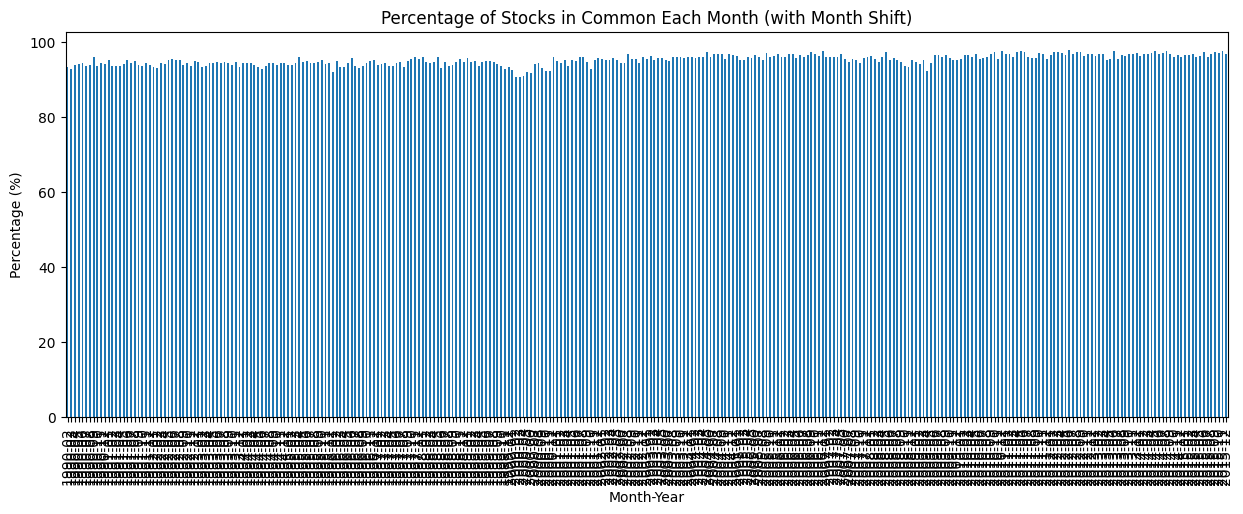

In [11]:
import matplotlib.pyplot as plt

# Plot the percentages
lookahead_bias_percentage.plot(kind='bar', figsize=(15, 5))
plt.title('Percentage of Stocks in Common Each Month (with Month Shift)')
plt.xlabel('Month-Year')
plt.ylabel('Percentage (%)')
plt.show()


In [37]:
# Count the number of True and False values in the lookahead_bias_check series
bias_count = lookahead_bias_check.value_counts()

# Output the count
print(bias_count)


False    311
dtype: int64


In [12]:
original

,Unnamed: 0,date,TICKER,RET,Adj_RET_Mkt,Adj_RET_Mkt_SMB,Adj_RET_Mkt_SMB_HML,MonthYear
0,0,1990-02-01,SUNW,0.012903,7.292903,8.532903,7.682903,1990-02
1,243076,1990-02-01,MYG,0.014085,7.294085,8.534085,7.684085,1990-02
2,1688937,1990-02-01,INTC,-0.012658,7.267342,8.507342,7.657342,1990-02
3,1680427,1990-02-01,CB,0.005634,7.285634,8.525634,7.675634,1990-02
4,1675688,1990-02-01,BUD,-0.026490,7.253510,8.493510,7.643510,1990-02
...,...,...,...,...,...,...,...,...
3266862,228605,2015-12-31,KMI,0.026135,-0.533865,-4.133865,-3.713865,2015-12
3266863,66360,2015-12-31,ADM,-0.005423,-0.565423,-4.165423,-3.745423,2015-12
3266864,374087,2015-12-31,HPE,-0.005236,-0.565236,-4.165236,-3.745236,2015-12
3266865,954405,2015-12-31,DIS,-0.011849,-0.571849,-4.171849,-3.751849,2015-12


In [13]:
rates=pd.read_csv('../data/FEDFUNDS.csv')

In [14]:
rates

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
828,2023-07-01,5.12
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33


In [15]:
# Convert date columns to datetime format
original['date'] = pd.to_datetime(original['date'])
rates['DATE'] = pd.to_datetime(rates['DATE'])

# Extract year and month for merging
original['YearMonth'] = original['date'].dt.to_period('M')
rates['YearMonth'] = rates['DATE'].dt.to_period('M')

# Merge the datasets on YearMonth
merged_data = pd.merge(original, rates, on='YearMonth', how='left')

# Drop additional columns if needed (like the original DATE column from rates)
merged_data = merged_data.drop(columns=['DATE', 'YearMonth'])

# Save the merged dataset to a new CSV file if needed
merged_data.to_csv('merged_data.csv', index=False)

In [16]:
merged_data

,Unnamed: 0,date,TICKER,RET,Adj_RET_Mkt,Adj_RET_Mkt_SMB,Adj_RET_Mkt_SMB_HML,MonthYear,FEDFUNDS
0,0,1990-02-01,SUNW,0.012903,7.292903,8.532903,7.682903,1990-02,8.24
1,243076,1990-02-01,MYG,0.014085,7.294085,8.534085,7.684085,1990-02,8.24
2,1688937,1990-02-01,INTC,-0.012658,7.267342,8.507342,7.657342,1990-02,8.24
3,1680427,1990-02-01,CB,0.005634,7.285634,8.525634,7.675634,1990-02,8.24
4,1675688,1990-02-01,BUD,-0.026490,7.253510,8.493510,7.643510,1990-02,8.24
...,...,...,...,...,...,...,...,...,...
3266862,228605,2015-12-31,KMI,0.026135,-0.533865,-4.133865,-3.713865,2015-12,0.24
3266863,66360,2015-12-31,ADM,-0.005423,-0.565423,-4.165423,-3.745423,2015-12,0.24
3266864,374087,2015-12-31,HPE,-0.005236,-0.565236,-4.165236,-3.745236,2015-12,0.24
3266865,954405,2015-12-31,DIS,-0.011849,-0.571849,-4.171849,-3.751849,2015-12,0.24
